In [ ]:
!pip install scikeras

In [ ]:
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = '/content/drive/MyDrive/Stock data/OHLC_VN30F1M.csv'
VN30 = pd.read_csv(file_path)

In [ ]:
VN30 = VN30.drop(columns=['Symbol', 'Resolution', 'Last Updated', 'Timestamp'])

In [ ]:
VN30['Time'] = pd.to_datetime(VN30['Time'])
VN30.set_index('Time', inplace=True)

In [ ]:
print(VN30.isnull().sum())

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


In [ ]:
df = VN30.copy()

In [ ]:
df.head()

,Open,High,Low,Close,Volume
Time,,,,,
2018-08-13 02:00:00,943.5,943.5,942.9,942.9,975.0
2018-08-13 02:01:00,943.0,943.1,942.9,943.1,220.0
2018-08-13 02:02:00,943.0,943.6,943.0,943.5,121.0
2018-08-13 02:03:00,943.3,943.4,943.3,943.4,135.0
2018-08-13 02:04:00,943.2,943.2,943.0,943.1,361.0


In [ ]:
# import tensorflow as tf

# gpus = tf.config.list_physical_devices('GPU')
# if gpus:
#     try:
#         # Option 1: Cap memory use (EXCLUSIVE mode)
#         tf.config.set_logical_device_configuration(
#             gpus[0],
#             [tf.config.LogicalDeviceConfiguration(memory_limit=14000)]  # 14 GB
#         )


#     except RuntimeError as e:
#         print("GPU configuration must happen before TF runtime init:", e)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization, Bidirectional, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import TimeSeriesSplit
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

# 1. Label the data
df["pct_change"] = df["Close"].pct_change(15) * 100

def label(pct):
    if pct > 0.1:
        return 2
    elif pct < -0.1:
        return 0
    else:
        return 1

df["label"] = df["pct_change"].apply(label)

In [ ]:
split_time = df.index[-1] - pd.Timedelta(days=30)
df_train = df[df.index < split_time].copy()
df_test = df[df.index >= split_time].copy()


In [ ]:
def add_features(X_raw):
    X_feat = X_raw.copy()
    X_feat["ma_5"] = X_feat["Close"].rolling(5).mean()
    X_feat["ma_10"] = X_feat["Close"].rolling(10).mean()
    X_feat["std_5"] = X_feat["Close"].rolling(5).std()
    X_feat["return_1"] = X_feat["Close"].pct_change(1)
    X_feat["volume_change"] = X_feat["Volume"].pct_change(1)
    X_feat["rsi_5"] = X_feat["Close"].diff().apply(lambda x: x if x > 0 else 0).rolling(5).mean() / (
        X_feat["Close"].diff().abs().rolling(5).mean())
    return X_feat.dropna()

X_train_full = add_features(df_train.drop(columns=["pct_change", "label"]))
X_test_full = add_features(df_test.drop(columns=["pct_change", "label"]))


                   Open      High       Low     Close    Volume      ma_5  \
Open           1.000000  0.999997  0.999997  0.999995  0.048813  0.999994   
High           0.999997  1.000000  0.999996  0.999998  0.049391  0.999993   
Low            0.999997  0.999996  1.000000  0.999998  0.048204  0.999992   
Close          0.999995  0.999998  0.999998  1.000000  0.048794  0.999991   
Volume         0.048813  0.049391  0.048204  0.048794  1.000000  0.048850   
ma_5           0.999994  0.999993  0.999992  0.999991  0.048850  1.000000   
ma_10          0.999982  0.999981  0.999979  0.999978  0.048914  0.999994   
std_5          0.112811  0.113614  0.111989  0.112799  0.375689  0.112704   
return_1      -0.000543  0.000687  0.000697  0.001786 -0.005382 -0.001224   
volume_change  0.002507  0.002509  0.002506  0.002510  0.189448  0.002521   
rsi_5         -0.006540 -0.006051 -0.005959 -0.005555 -0.004332 -0.007844   
label         -0.001757 -0.001535 -0.001356 -0.001217 -0.016602 -0.002582   

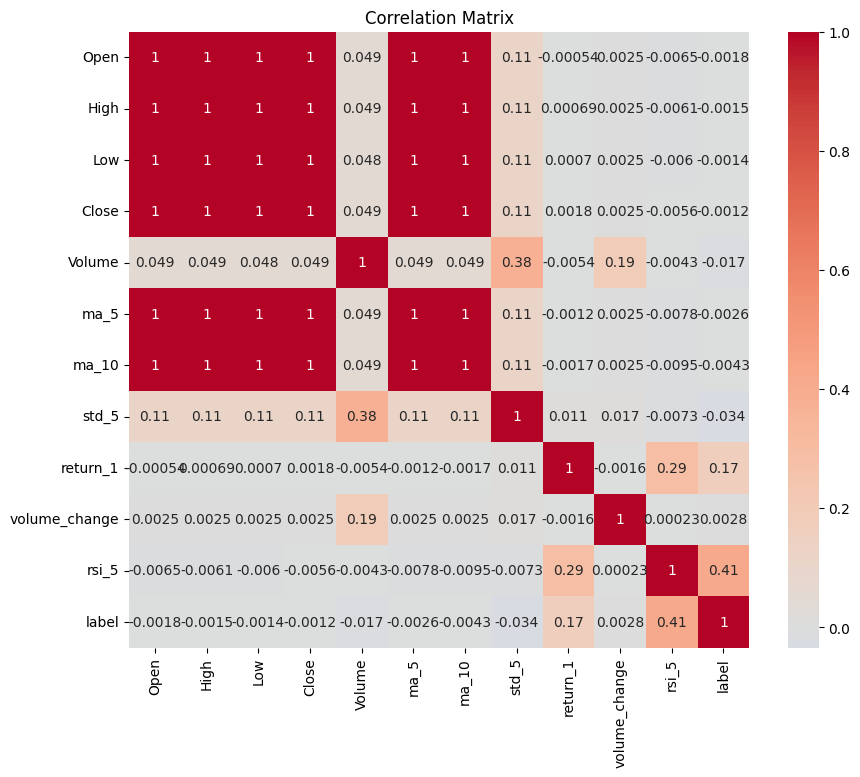


Correlation with label:
label            1.000000
rsi_5            0.414348
return_1         0.171642
volume_change    0.002828
Close           -0.001217
Low             -0.001356
High            -0.001535
Open            -0.001757
ma_5            -0.002582
ma_10           -0.004333
Volume          -0.016602
std_5           -0.034067
Name: label, dtype: float64


In [ ]:
# Recombine label to compute correlation with features
X_train_corr = X_train_full.copy()
X_train_corr["label"] = df_train.loc[X_train_full.index, "label"]

# Compute correlation matrix
corr_matrix = X_train_corr.corr()

# Print full matrix
print(corr_matrix)

# Optional: Visualize heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Matrix")
plt.show()

# To specifically see correlations with the label
print("\nCorrelation with label:")
print(corr_matrix["label"].sort_values(ascending=False))


In [ ]:
# Define selected features
selected_features = [
    "Close",
    "std_5",
    "return_1",
    "volume_change",
    "rsi_5"
]

# Reassign filtered feature sets
X_train = X_train_full[selected_features]
X_test = X_test_full[selected_features]

In [ ]:
y_train = df_train["label"].loc[X_train.index]
y_test = df_test["label"].loc[X_test.index]

In [ ]:
scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

In [ ]:
def create_sequences(X, y, window_size):
    Xs, ys = [], []
    for i in range(window_size, len(X)):
        Xs.append(X.iloc[i-window_size:i].values)
        ys.append(y.iloc[i])
    return np.array(Xs), np.array(ys)

window_size = 15
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, window_size)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, window_size)


In [ ]:
classes = np.unique(y_train_seq)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_seq)
class_weight_dict = dict(zip(classes, class_weights))

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
def build_model(units=100, dropout_rate=0.5, learning_rate=1e-4):
    model = Sequential([
        Input(shape=(window_size, X_train_scaled.shape[1])),
        Conv1D(64, kernel_size=3, activation='relu', padding='same'),
        MaxPooling1D(pool_size=2),
        Conv1D(128, kernel_size=3, activation='relu', padding='same'),
        MaxPooling1D(pool_size=2),
        Conv1D(64, kernel_size=3, activation='relu', padding='same'),
        BatchNormalization(),
        Dropout(dropout_rate),
        Bidirectional(LSTM(units, return_sequences=True)),
        Dropout(dropout_rate),
        Bidirectional(LSTM(units)),
        Dropout(dropout_rate),
        Dense(64, activation='relu'),
        Dense(3, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
# import tensorflow as tf
# print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
# print("TensorFlow is using GPU:", tf.test.is_gpu_available())


In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score

best_val_acc = 0
best_params = None
results = []

tscv = TimeSeriesSplit(n_splits=3)

for units in [64, 100]:
    for dropout_rate in [0.3, 0.5]:
        for learning_rate in [1e-3, 1e-4]:
            print(f"\n Training with units={units}, dropout_rate={dropout_rate}, learning_rate={learning_rate}")
            fold_accuracies = []
            fold_num = 1

            for train_idx, val_idx in tscv.split(X_train_seq):
                print(f"  Fold {fold_num} started...")
                X_train_fold, X_val_fold = X_train_seq[train_idx], X_train_seq[val_idx]
                y_train_fold, y_val_fold = y_train_seq[train_idx], y_train_seq[val_idx]

                model = build_model(units=units, dropout_rate=dropout_rate, learning_rate=learning_rate)

                history = model.fit(
                    X_train_fold, y_train_fold,
                    epochs=30,
                    batch_size=128,
                    validation_data=(X_val_fold, y_val_fold),
                    class_weight=class_weight_dict,
                    callbacks=[early_stop],
                    verbose=0
                )

                val_pred = model.predict(X_val_fold).argmax(axis=1)
                val_acc = accuracy_score(y_val_fold, val_pred)
                fold_accuracies.append(val_acc)

                print(f"  Fold {fold_num} complete - val_accuracy: {val_acc:.4f}")
                fold_num += 1

            avg_val_acc = np.mean(fold_accuracies)
            results.append((units, dropout_rate, learning_rate, avg_val_acc))
            print(f"   Avg Validation Accuracy: {avg_val_acc:.4f}")

            if avg_val_acc > best_val_acc:
                best_val_acc = avg_val_acc
                best_params = (units, dropout_rate, learning_rate)
print("\n Best Validation Accuracy:", best_val_acc)
print(" Best Parameters:")
print("  units:", best_params[0])
print("  dropout_rate:", best_params[1])
print("  learning_rate:", best_params[2])
0.0


 Training with units=64, dropout_rate=0.3, learning_rate=0.001
  Fold 1 started...
2770/2770 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step
  Fold 1 complete - val_accuracy: 0.8139
  Fold 2 started...
2770/2770 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step
  Fold 2 complete - val_accuracy: 0.8388
  Fold 3 started...
2770/2770 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step
  Fold 3 complete - val_accuracy: 0.8550
   Avg Validation Accuracy: 0.8359

 Training with units=64, dropout_rate=0.3, learning_rate=0.0001
  Fold 1 started...
2770/2770 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step
  Fold 1 complete - val_accuracy: 0.7934
  Fold 2 started...
2770/2770 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step
  Fold 2 complete - val_accuracy: 0.8450
  Fold 3 started...
2770/2770 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step
  Fold 3 complete - val_accuracy: 0.8283
   Avg Validation Accuracy: 0.8222

 Training with units=64, dropout_rate=0.5, learning_rate=0.001
  Fold 1 started...
2770/2770 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step
  Fold 1 complete - val_accuracy: 0.8093
  

In [ ]:
best_model = build_model(
    units=best_params[0],
    dropout_rate=best_params[1],
    learning_rate=best_params[2]
)

history = best_model.fit(
    X_train_seq, y_train_seq,
    epochs=50,
    batch_size=64,
    validation_data=(X_test_seq, y_test_seq),
    class_weight=class_weight_dict,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50
5539/5539 ━━━━━━━━━━━━━━━━━━━━ 155s 26ms/step - accuracy: 0.7487 - loss: 0.5065 - val_accuracy: 0.8755 - val_loss: 0.3063
Epoch 2/50
5539/5539 ━━━━━━━━━━━━━━━━━━━━ 201s 26ms/step - accuracy: 0.8187 - loss: 0.3830 - val_accuracy: 0.7841 - val_loss: 0.4887
Epoch 3/50
5539/5539 ━━━━━━━━━━━━━━━━━━━━ 145s 26ms/step - accuracy: 0.8303 - loss: 0.3649 - val_accuracy: 0.7668 - val_loss: 0.4961
Epoch 4/50
5539/5539 ━━━━━━━━━━━━━━━━━━━━ 202s 26ms/step - accuracy: 0.8336 - loss: 0.3570 - val_accuracy: 0.7225 - val_loss: 0.6558
Epoch 5/50
5539/5539 ━━━━━━━━━━━━━━━━━━━━ 200s 26ms/step - accuracy: 0.8342 - loss: 0.3533 - val_accuracy: 0.8248 - val_loss: 0.4140
Epoch 6/50
5539/5539 ━━━━━━━━━━━━━━━━━━━━ 145s 26ms/step - accuracy: 0.8383 - loss: 0.3463 - val_accuracy: 0.8389 - val_loss: 0.3796


In [ ]:
y_pred = best_model.predict(X_test_seq)
y_pred_labels = y_pred.argmax(axis=1)

print("Confusion Matrix:")
print(confusion_matrix(y_test_seq, y_pred_labels))
print("\nClassification Report:")
print(classification_report(y_test_seq, y_pred_labels, target_names=['Down', 'Neutral', 'Up']))

158/158 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
Confusion Matrix:
[[ 763  197    1]
 [ 121 2877  167]
 [   4  137  768]]

Classification Report:
              precision    recall  f1-score   support

        Down       0.86      0.79      0.83       961
     Neutral       0.90      0.91      0.90      3165
          Up       0.82      0.84      0.83       909

    accuracy                           0.88      5035
   macro avg       0.86      0.85      0.85      5035
weighted avg       0.88      0.88      0.88      5035



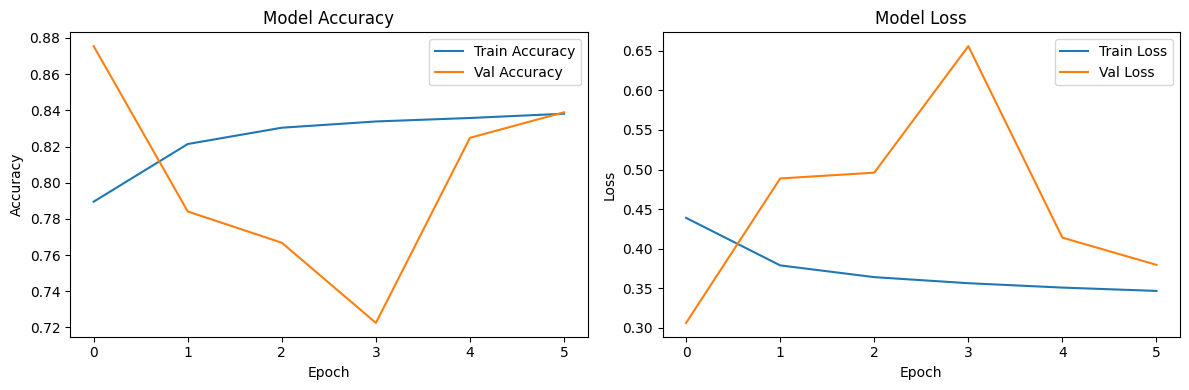

In [ ]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
